# Testing XGB on well log datasets 

In [1]:
import numpy as np
import pandas as pd

from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

import matplotlib.pyplot as plt
from coremdlr.viz import model_plots

Using TensorFlow backend.
/home/administrator/code/python/coremdlr/coremdlr/viz/__init__.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
 

In [2]:
from coremdlr.datasets.utils import available_wells

wells = list(available_wells())
wells, len(wells)

(['204-24a-6',
  '204-24a-7',
  '204-20-3',
  '204-20-2',
  '204-19-3A',
  '205-21b-3',
  '204-20a-7',
  '204-19-7',
  '204-19-6',
  '204-20-6a',
  '204-20-1Z',
  '204-20-1'],
 12)

### Picking your training and testing wells

In [3]:
# May need to fiddle with these to make sure there is at least
# one example of 'oilstained' in the test wells, particularly an
# issue with higher resolution multipliers.
TRAIN_WELLS = wells[:10]
TEST_WELLS = wells[10:]

In [4]:
import hyperopt

from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

fmodel_args = {
    'logs': {
        'model': 'LambdaModel',
        'model_args': {'feature': 'logs'}
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config, fdset):
    """
    Train function given model_config dict of params, and FaciesDataset instance
    """
    xgb_predictor = FeaturePredictor(fdset, model_args=model_config, feature_model_args=fmodel_args)
    
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    
    sample_weights = compute_sample_weight('balanced', fdset.y_test) 
    
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test), sample_weight=sample_weights)


def make_params_usable(params):
    """
    Convert params returned by hyperopt to usable `model_args`
    """
    return {
        **XGB_SEARCH_SPACE,
        **params,
        **{'max_depth' : int(params['max_depth']),
           'n_estimators' : int(params['n_estimators'])}
    }

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (6500,)), ('top', (6500,)), ('base', (6500,)), ('logs', (6500, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (9650,)), ('top', (9650,)), ('base', (9650,)), ('logs', (9650, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (5460,)), ('top', (5460,)), ('base', (5460,)), ('logs', (5460, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (1465,)), ('top', (1465,)), ('base', (1465,)), ('logs', (1465, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (4793,)), ('top', (4793,)), ('base', (4793,)), ('logs', (4793, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (1920,)), ('top', (1920,)), ('base', (1920,)), ('logs', (1920, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1548,)), ('top', (1548,)), ('base', (1548,)), ('logs', (1548, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (4905,)), ('top', (4905,)), ('base', (4905,)), ('logs', (4905, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (944,)), ('top', (944,)), ('base', (944,)), ('logs', (944, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1770,)), ('top', (1770,)), ('base', (1770,)), ('logs', (1770, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (957,)), ('top', (957,)), ('base', (957,)), ('logs', (957, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (5600,)), ('top', (5600,)), ('base', (5600,)), ('logs', (5600, 11))]
Training model for feature:  logs
F1 score: 0.19355913047363296
Training model for feature:  logs
F1 score: 0.16927715622338768
Training model for feature:  logs
F1 score: 0.20452341637296806
Training model for feature:  logs
F1 score: 0.2149595678403145
Training model for feature:  logs
F1 score: 0.1763658196930336
Training model for feature:  logs
F1 score: 0.19692579034192356
Training model for feature:  logs
F1 score: 0.18179643486414204
Training model for feature:  logs
F1 score: 0.19934066786675397
Training model for feature:  logs
F1 score: 0.1902883806979875
Training model for feature:  logs
F1 score: 0.2007785682200504
Training model for feature:  logs
F1 score: 0.17506644983657238
Training model for feature:  logs
F1 score: 0.19326886295701842
Training model for feature:  logs
F1 score: 0.1942525888372709
Training model for feature:  log

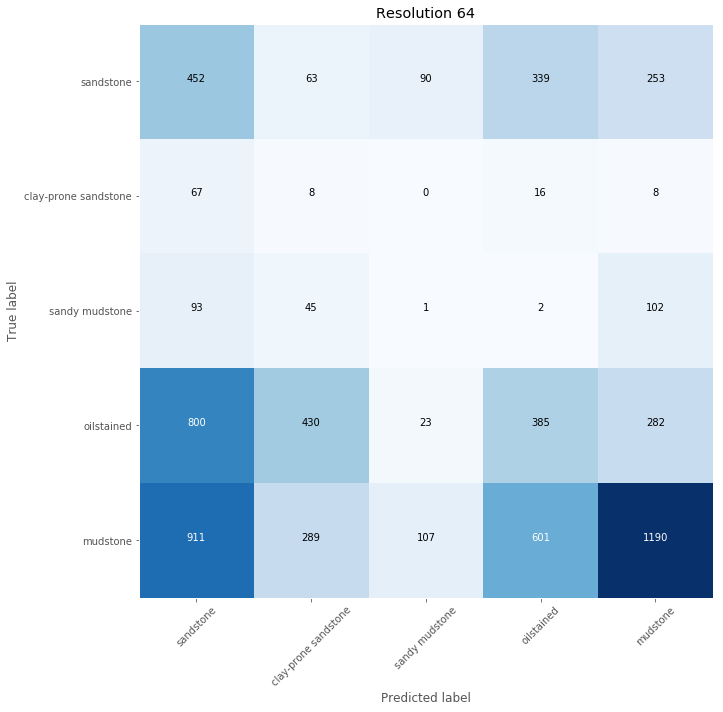

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3253,)), ('top', (3253,)), ('base', (3253,)), ('logs', (3253, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (4821,)), ('top', (4821,)), ('base', (4821,)), ('logs', (4821, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2732,)), ('top', (2732,)), ('base', (2732,)), ('logs', (2732, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (732,)), ('top', (732,)), ('base', (732,)), ('logs', (732, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (2397,)), ('top', (2397,)), ('base', (2397,)), ('logs', (2397, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (960,)), ('top', (960,)), ('base', (960,)), ('logs', (960, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (775,)), ('top', (775,)), ('base', (775,)), ('logs', (775, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (2456,)), ('top', (2456,)), ('base', (2456,)), ('logs', (2456, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (473,)), ('top', (473,)), ('base', (473,)), ('logs', (473, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (883,)), ('top', (883,)), ('base', (883,)), ('logs', (883, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (481,)), ('top', (481,)), ('base', (481,)), ('logs', (481, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (2802,)), ('top', (2802,)), ('base', (2802,)), ('logs', (2802, 11))]
Training model for feature:  logs
F1 score: 0.1676192159536944
Training model for feature:  logs
F1 score: 0.1957480991366692
Training model for feature:  logs
F1 score: 0.20778171893878214
Training model for feature:  logs
F1 score: 0.18136213671803025
Training model for feature:  logs
F1 score: 0.18977211925350135
Training model for feature:  logs
F1 score: 0.22170152727736742
Training model for feature:  logs
F1 score: 0.18698076306518044
Training model for feature:  logs
F1 score: 0.20217524461707473
Training model for feature:  logs
F1 score: 0.21824583810023102
Training model for feature:  logs
F1 score: 0.18955876201093794
Training model for feature:  logs
F1 score: 0.15292894508225735
Training model for feature:  logs
F1 score: 0.20189435731113434
Training model for feature:  logs
F1 score: 0.2228159827749797
Training model for feature:  l

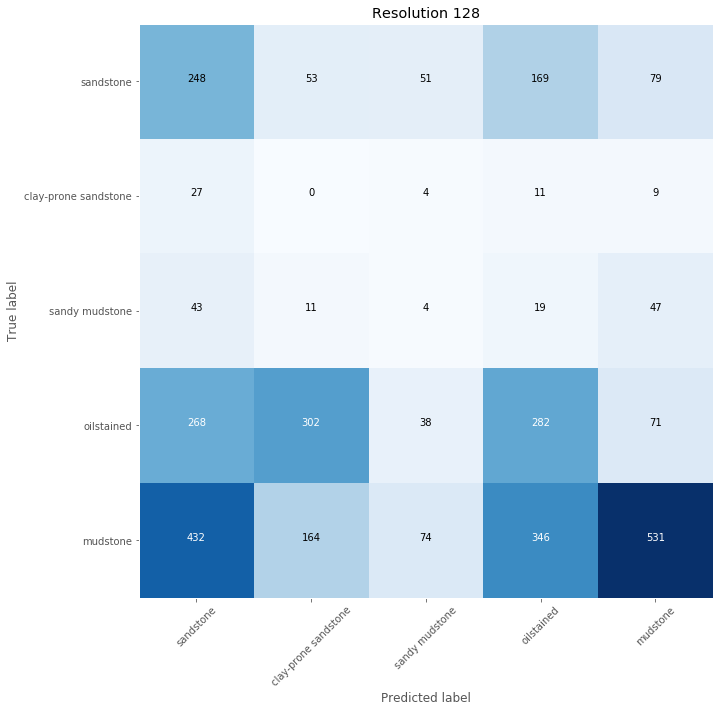

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1626,)), ('top', (1626,)), ('base', (1626,)), ('logs', (1626, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (2400,)), ('top', (2400,)), ('base', (2400,)), ('logs', (2400, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (1362,)), ('top', (1362,)), ('base', (1362,)), ('logs', (1362, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (369,)), ('top', (369,)), ('base', (369,)), ('logs', (369, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1205,)), ('top', (1205,)), ('base', (1205,)), ('logs', (1205, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (477,)), ('top', (477,)), ('base', (477,)), ('logs', (477, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (391,)), ('top', (391,)), ('base', (391,)), ('logs', (391, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1223,)), ('top', (1223,)), ('base', (1223,)), ('logs', (1223, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (235,)), ('top', (235,)), ('base', (235,)), ('logs', (235, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (441,)), ('top', (441,)), ('base', (441,)), ('logs', (441, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (240,)), ('top', (240,)), ('base', (240,)), ('logs', (240, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1401,)), ('top', (1401,)), ('base', (1401,)), ('logs', (1401, 11))]
Training model for feature:  logs
F1 score: 0.18563996865373317
Training model for feature:  logs
F1 score: 0.15868083578555234
Training model for feature:  logs
F1 score: 0.1731229851098548
Training model for feature:  logs
F1 score: 0.15714112910355899
Training model for feature:  logs
F1 score: 0.1984067466213076
Training model for feature:  logs
F1 score: 0.18159417213816914
Training model for feature:  logs
F1 score: 0.1829029756769514
Training model for feature:  logs
F1 score: 0.2117620031410607
Training model for feature:  logs
F1 score: 0.2314235414699708
Training model for feature:  logs
F1 score: 0.16814826882656672
Training model for feature:  logs
F1 score: 0.17876868795958084
Training model for feature:  logs
F1 score: 0.21824471173969986
Training model for feature:  logs
F1 score: 0.2091353979961851
Training model for feature:  logs

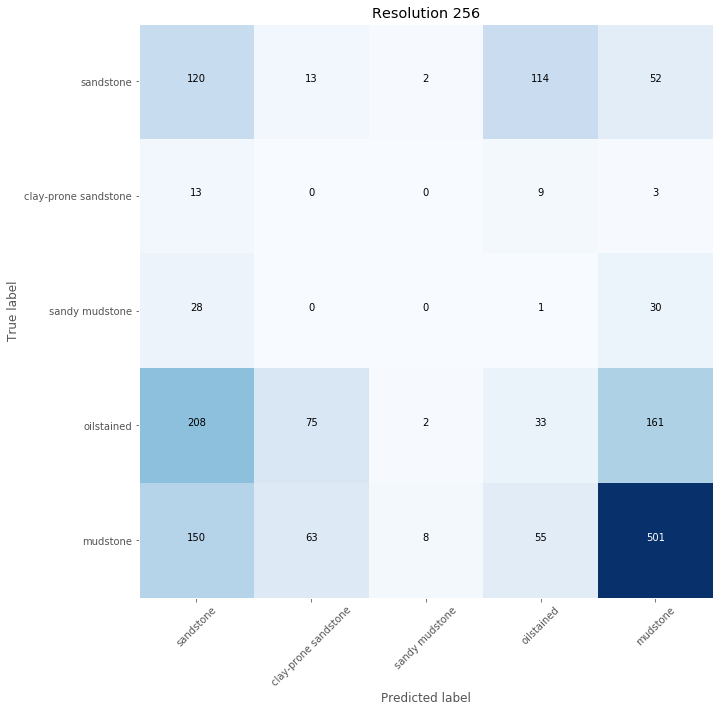

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1304,)), ('top', (1304,)), ('base', (1304,)), ('logs', (1304, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (1928,)), ('top', (1928,)), ('base', (1928,)), ('logs', (1928, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (1094,)), ('top', (1094,)), ('base', (1094,)), ('logs', (1094, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (297,)), ('top', (297,)), ('base', (297,)), ('logs', (297, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (955,)), ('top', (955,)), ('base', (955,)), ('logs', (955, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (384,)), ('top', (384,)), ('base', (384,)), ('logs', (384, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (311,)), ('top', (311,)), ('base', (311,)), ('logs', (311, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (982,)), ('top', (982,)), ('base', (982,)), ('logs', (982, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (193,)), ('top', (193,)), ('base', (193,)), ('logs', (193, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (355,)), ('top', (355,)), ('base', (355,)), ('logs', (355, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (190,)), ('top', (190,)), ('base', (190,)), ('logs', (190, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1119,)), ('top', (1119,)), ('base', (1119,)), ('logs', (1119, 11))]
Training model for feature:  logs
F1 score: 0.17217767169308631
Training model for feature:  logs
F1 score: 0.15768488196631186
Training model for feature:  logs
F1 score: 0.16643862318534242
Training model for feature:  logs
F1 score: 0.17280927638063118
Training model for feature:  logs
F1 score: 0.19157808468389514
Training model for feature:  logs
F1 score: 0.17454007302915855
Training model for feature:  logs
F1 score: 0.17327435563478186
Training model for feature:  logs
F1 score: 0.160161178066205
Training model for feature:  logs
F1 score: 0.17655733980368318
Training model for feature:  logs
F1 score: 0.23900593509883938
Training model for feature:  logs
F1 score: 0.1673133456977837
Training model for feature:  logs
F1 score: 0.155481462414054
Training model for feature:  logs
F1 score: 0.16270098798747964
Training model for feature:  log

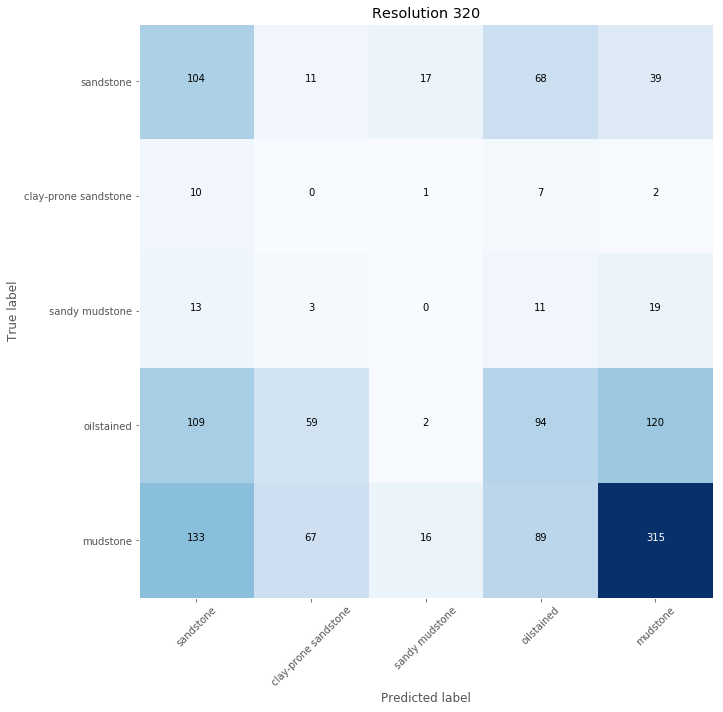

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1086,)), ('top', (1086,)), ('base', (1086,)), ('logs', (1086, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (1606,)), ('top', (1606,)), ('base', (1606,)), ('logs', (1606, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (915,)), ('top', (915,)), ('base', (915,)), ('logs', (915, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (245,)), ('top', (245,)), ('base', (245,)), ('logs', (245, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (803,)), ('top', (803,)), ('base', (803,)), ('logs', (803, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (321,)), ('top', (321,)), ('base', (321,)), ('logs', (321, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (262,)), ('top', (262,)), ('base', (262,)), ('logs', (262, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (822,)), ('top', (822,)), ('base', (822,)), ('logs', (822, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (158,)), ('top', (158,)), ('base', (158,)), ('logs', (158, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (298,)), ('top', (298,)), ('base', (298,)), ('logs', (298, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (163,)), ('top', (163,)), ('base', (163,)), ('logs', (163, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (932,)), ('top', (932,)), ('base', (932,)), ('logs', (932, 11))]
Training model for feature:  logs
F1 score: 0.20259962032158488
Training model for feature:  logs
F1 score: 0.14200204392122867
Training model for feature:  logs
F1 score: 0.20079186933968426
Training model for feature:  logs
F1 score: 0.22390440723722177
Training model for feature:  logs
F1 score: 0.22368940416448724
Training model for feature:  logs
F1 score: 0.17785372835492924
Training model for feature:  logs
F1 score: 0.1929250162498003
Training model for feature:  logs
F1 score: 0.1988374375229499
Training model for feature:  logs
F1 score: 0.19432746136887186
Training model for feature:  logs
F1 score: 0.19582458266460973
Training model for feature:  logs
F1 score: 0.20235940529674581
Training model for feature:  logs
F1 score: 0.16398427863952708
Training model for feature:  logs
F1 score: 0.18779179588354009
Training model for feature:  logs

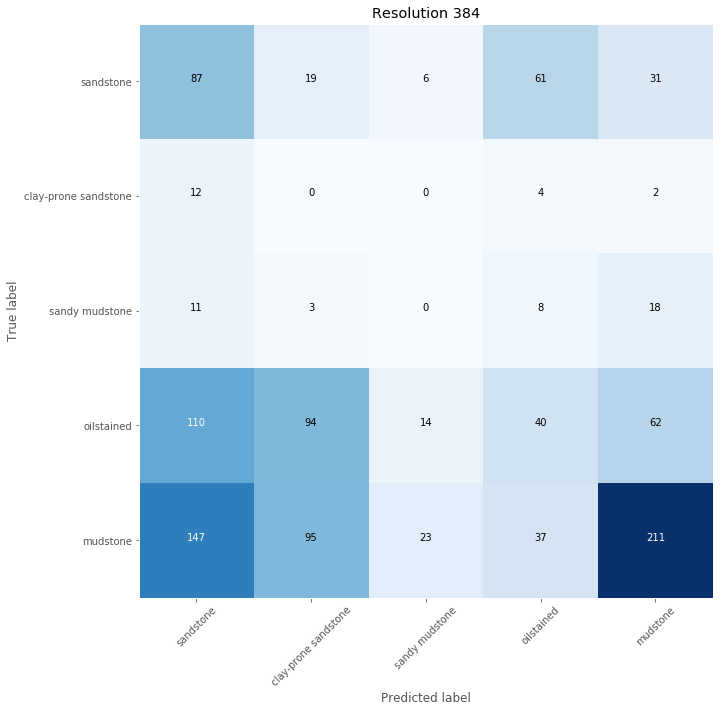

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (820,)), ('top', (820,)), ('base', (820,)), ('logs', (820, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (1208,)), ('top', (1208,)), ('base', (1208,)), ('logs', (1208, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (686,)), ('top', (686,)), ('base', (686,)), ('logs', (686, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (186,)), ('top', (186,)), ('base', (186,)), ('logs', (186, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (598,)), ('top', (598,)), ('base', (598,)), ('logs', (598, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (242,)), ('top', (242,)), ('base', (242,)), ('logs', (242, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (190,)), ('top', (190,)), ('base', (190,)), ('logs', (190, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (609,)), ('top', (609,)), ('base', (609,)), ('logs', (609, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (116,)), ('top', (116,)), ('base', (116,)), ('logs', (116, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (225,)), ('top', (225,)), ('base', (225,)), ('logs', (225, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (123,)), ('top', (123,)), ('base', (123,)), ('logs', (123, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (703,)), ('top', (703,)), ('base', (703,)), ('logs', (703, 11))]
Training model for feature:  logs
F1 score: 0.18204284795881878
Training model for feature:  logs
F1 score: 0.2270883933691345
Training model for feature:  logs
F1 score: 0.14845057112230436
Training model for feature:  logs
F1 score: 0.21696011608023574
Training model for feature:  logs
F1 score: 0.2535275129937083
Training model for feature:  logs
F1 score: 0.1930002725842867
Training model for feature:  logs
F1 score: 0.16070739984519913
Training model for feature:  logs
F1 score: 0.16569110931263686
Training model for feature:  logs
F1 score: 0.17667933982670894
Training model for feature:  logs
F1 score: 0.17296579648862828
Training model for feature:  logs
F1 score: 0.22002139111709748
Training model for feature:  logs
F1 score: 0.2116328373926008
Training model for feature:  logs
F1 score: 0.19988494030421605
Training model for feature:  logs
F

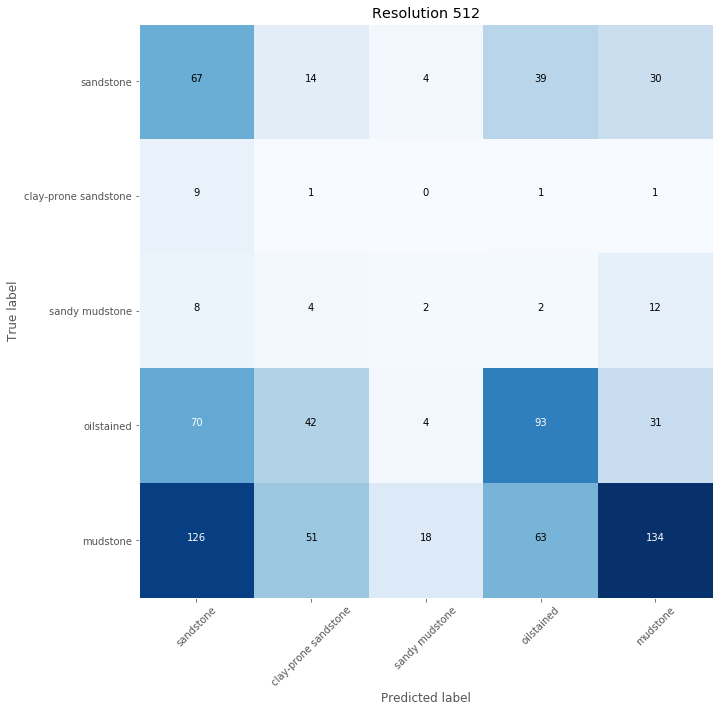

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (658,)), ('top', (658,)), ('base', (658,)), ('logs', (658, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (973,)), ('top', (973,)), ('base', (973,)), ('logs', (973, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (545,)), ('top', (545,)), ('base', (545,)), ('logs', (545, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (149,)), ('top', (149,)), ('base', (149,)), ('logs', (149, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (484,)), ('top', (484,)), ('base', (484,)), ('logs', (484, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (192,)), ('top', (192,)), ('base', (192,)), ('logs', (192, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (154,)), ('top', (154,)), ('base', (154,)), ('logs', (154, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (489,)), ('top', (489,)), ('base', (489,)), ('logs', (489, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (93,)), ('top', (93,)), ('base', (93,)), ('logs', (93, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (174,)), ('top', (174,)), ('base', (174,)), ('logs', (174, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (98,)), ('top', (98,)), ('base', (98,)), ('logs', (98, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (561,)), ('top', (561,)), ('base', (561,)), ('logs', (561, 11))]
Training model for feature:  logs
F1 score: 0.1755850131476699
Training model for feature:  logs
F1 score: 0.20471608411064962
Training model for feature:  logs
F1 score: 0.16419206456294866
Training model for feature:  logs
F1 score: 0.19225197793962578
Training model for feature:  logs
F1 score: 0.16732975703920014
Training model for feature:  logs
F1 score: 0.17271845193165442
Training model for feature:  logs
F1 score: 0.18022915834492326
Training model for feature:  logs
F1 score: 0.19230591722493467
Training model for feature:  logs
F1 score: 0.16232878615637236
Training model for feature:  logs
F1 score: 0.20091240125615126
Training model for feature:  logs
F1 score: 0.22076058116071162
Training model for feature:  logs
F1 score: 0.1851766571984817
Training model for feature:  logs
F1 score: 0.191255202160843
Training model for feature:  logs
F

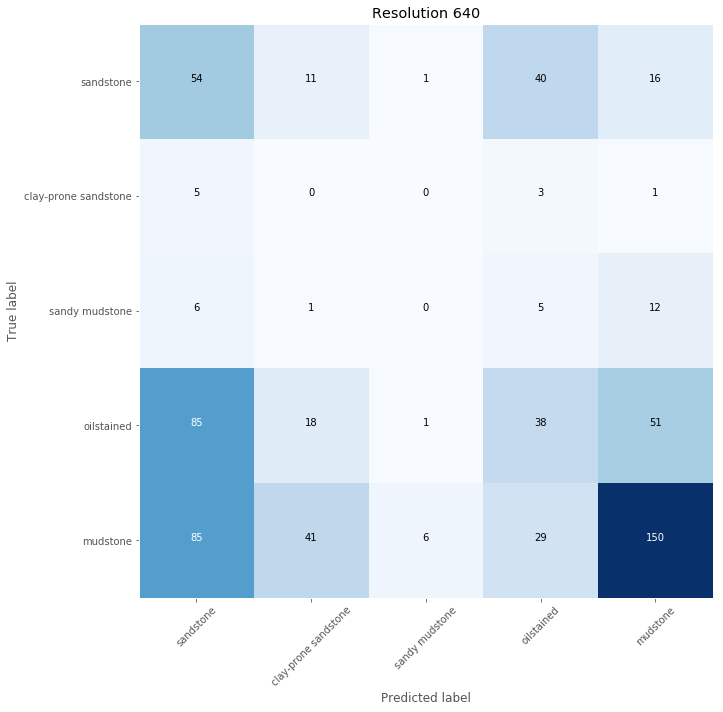

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (547,)), ('top', (547,)), ('base', (547,)), ('logs', (547, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (817,)), ('top', (817,)), ('base', (817,)), ('logs', (817, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (463,)), ('top', (463,)), ('base', (463,)), ('logs', (463, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (121,)), ('top', (121,)), ('base', (121,)), ('logs', (121, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (412,)), ('top', (412,)), ('base', (412,)), ('logs', (412, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (155,)), ('top', (155,)), ('base', (155,)), ('logs', (155, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (129,)), ('top', (129,)), ('base', (129,)), ('logs', (129, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (406,)), ('top', (406,)), ('base', (406,)), ('logs', (406, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (78,)), ('top', (78,)), ('base', (78,)), ('logs', (78, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (148,)), ('top', (148,)), ('base', (148,)), ('logs', (148, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (81,)), ('top', (81,)), ('base', (81,)), ('logs', (81, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (472,)), ('top', (472,)), ('base', (472,)), ('logs', (472, 11))]
Training model for feature:  logs
F1 score: 0.19582864673345404
Training model for feature:  logs
F1 score: 0.17654409283321287
Training model for feature:  logs
F1 score: 0.18930614951162653
Training model for feature:  logs
F1 score: 0.19868102775312307
Training model for feature:  logs
F1 score: 0.1923351744041399
Training model for feature:  logs
F1 score: 0.19998364654088535
Training model for feature:  logs
F1 score: 0.180069733915392
Training model for feature:  logs
F1 score: 0.1640426610018405
Training model for feature:  logs
F1 score: 0.13164095371669005
Training model for feature:  logs
F1 score: 0.1577300948412204
Training model for feature:  logs
F1 score: 0.18747854317869378
Training model for feature:  logs
F1 score: 0.17487317510806621
Training model for feature:  logs
F1 score: 0.19565951474684756
Training model for feature:  logs
F1

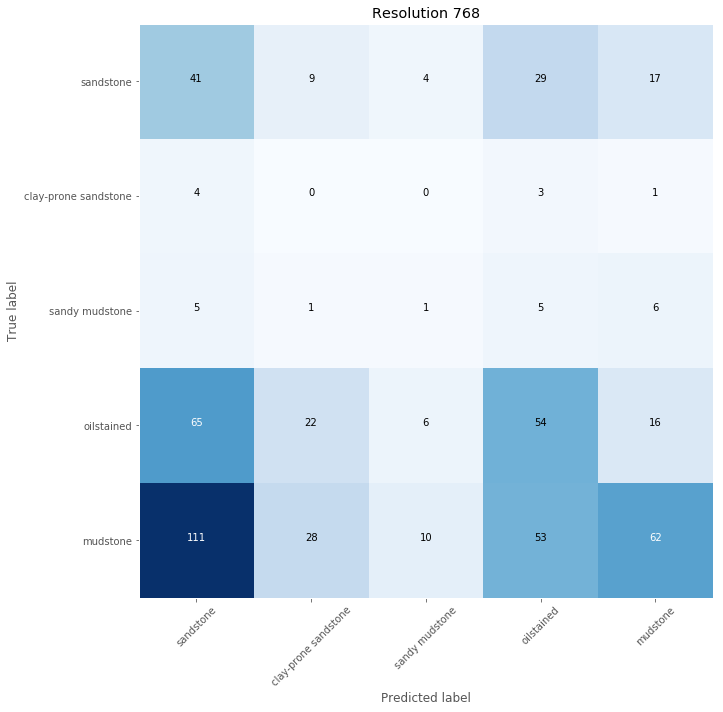

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (466,)), ('top', (466,)), ('base', (466,)), ('logs', (466, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (701,)), ('top', (701,)), ('base', (701,)), ('logs', (701, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (396,)), ('top', (396,)), ('base', (396,)), ('logs', (396, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (105,)), ('top', (105,)), ('base', (105,)), ('logs', (105, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (344,)), ('top', (344,)), ('base', (344,)), ('logs', (344, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (141,)), ('top', (141,)), ('base', (141,)), ('logs', (141, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (113,)), ('top', (113,)), ('base', (113,)), ('logs', (113, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (354,)), ('top', (354,)), ('base', (354,)), ('logs', (354, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (67,)), ('top', (67,)), ('base', (67,)), ('logs', (67, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (127,)), ('top', (127,)), ('base', (127,)), ('logs', (127, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (71,)), ('top', (71,)), ('base', (71,)), ('logs', (71, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (404,)), ('top', (404,)), ('base', (404,)), ('logs', (404, 11))]
Training model for feature:  logs
F1 score: 0.164459102514025
Training model for feature:  logs
F1 score: 0.18929047624699796
Training model for feature:  logs
F1 score: 0.1940999839590216
Training model for feature:  logs
F1 score: 0.1872855433162266
Training model for feature:  logs
F1 score: 0.1758846884135635
Training model for feature:  logs
F1 score: 0.16222917290842823
Training model for feature:  logs
F1 score: 0.1744059897176254
Training model for feature:  logs
F1 score: 0.17649918474807536
Training model for feature:  logs
F1 score: 0.1834347689291407
Training model for feature:  logs
F1 score: 0.1585615975422427
Training model for feature:  logs
F1 score: 0.20390562248995986
Training model for feature:  logs
F1 score: 0.16937522943484193
Training model for feature:  logs
F1 score: 0.20064903588488772
Training model for feature:  logs
F1 sc

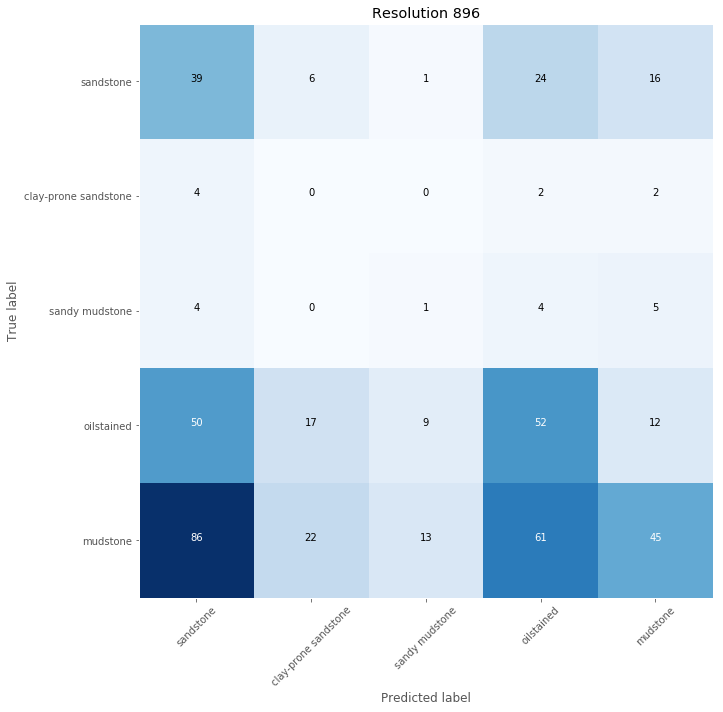

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (415,)), ('top', (415,)), ('base', (415,)), ('logs', (415, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (608,)), ('top', (608,)), ('base', (608,)), ('logs', (608, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (342,)), ('top', (342,)), ('base', (342,)), ('logs', (342, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (95,)), ('top', (95,)), ('base', (95,)), ('logs', (95, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (302,)), ('top', (302,)), ('base', (302,)), ('logs', (302, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (121,)), ('top', (121,)), ('base', (121,)), ('logs', (121, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (99,)), ('top', (99,)), ('base', (99,)), ('logs', (99, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (304,)), ('top', (304,)), ('base', (304,)), ('logs', (304, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (58,)), ('top', (58,)), ('base', (58,)), ('logs', (58, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (113,)), ('top', (113,)), ('base', (113,)), ('logs', (113, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (60,)), ('top', (60,)), ('base', (60,)), ('logs', (60, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (355,)), ('top', (355,)), ('base', (355,)), ('logs', (355, 11))]
Training model for feature:  logs
F1 score: 0.20930314476815354
Training model for feature:  logs
F1 score: 0.21444581353048173
Training model for feature:  logs
F1 score: 0.20543180416633194
Training model for feature:  logs
F1 score: 0.1897378922746827
Training model for feature:  logs
F1 score: 0.20342787788249833
Training model for feature:  logs
F1 score: 0.2003741209004367
Training model for feature:  logs
F1 score: 0.2034714161071279
Training model for feature:  logs
F1 score: 0.20514571038595295
Training model for feature:  logs
F1 score: 0.20629516661307132
Training model for feature:  logs
F1 score: 0.18192178301093356
Training model for feature:  logs
F1 score: 0.22528449502133713
Training model for feature:  logs
F1 score: 0.19273988624529365
Training model for feature:  logs
F1 score: 0.22228681976533857
Training model for feature:  logs


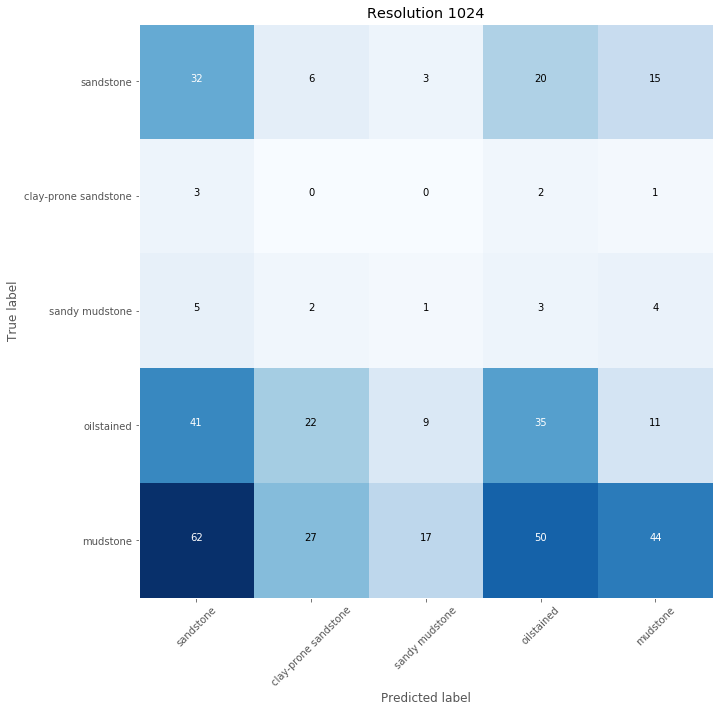

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (375,)), ('top', (375,)), ('base', (375,)), ('logs', (375, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (542,)), ('top', (542,)), ('base', (542,)), ('logs', (542, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (308,)), ('top', (308,)), ('base', (308,)), ('logs', (308, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (82,)), ('top', (82,)), ('base', (82,)), ('logs', (82, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (274,)), ('top', (274,)), ('base', (274,)), ('logs', (274, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (110,)), ('top', (110,)), ('base', (110,)), ('logs', (110, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (87,)), ('top', (87,)), ('base', (87,)), ('logs', (87, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (270,)), ('top', (270,)), ('base', (270,)), ('logs', (270, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (52,)), ('top', (52,)), ('base', (52,)), ('logs', (52, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (99,)), ('top', (99,)), ('base', (99,)), ('logs', (99, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (56,)), ('top', (56,)), ('base', (56,)), ('logs', (56, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (317,)), ('top', (317,)), ('base', (317,)), ('logs', (317, 11))]
Training model for feature:  logs
F1 score: 0.19776557623554297
Training model for feature:  logs
F1 score: 0.24102244822517577
Training model for feature:  logs
F1 score: 0.19539542583020847
Training model for feature:  logs
F1 score: 0.1707643794558209
Training model for feature:  logs
F1 score: 0.20241555459893812
Training model for feature:  logs
F1 score: 0.19738552265226922
Training model for feature:  logs
F1 score: 0.185145495951417
Training model for feature:  logs
F1 score: 0.19169198888643152
Training model for feature:  logs
F1 score: 0.19908741672474997
Training model for feature:  logs
F1 score: 0.23901176057574164
Training model for feature:  logs
F1 score: 0.1772686084142395
Training model for feature:  logs
F1 score: 0.2234481671667496
Training model for feature:  logs
F1 score: 0.2580477441150437
Training model for feature:  logs
F1 

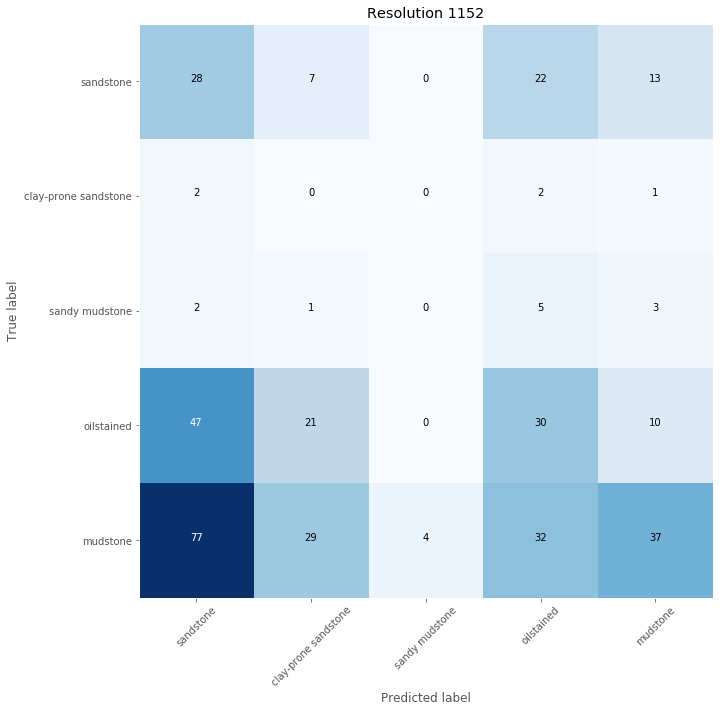

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (335,)), ('top', (335,)), ('base', (335,)), ('logs', (335, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (485,)), ('top', (485,)), ('base', (485,)), ('logs', (485, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (279,)), ('top', (279,)), ('base', (279,)), ('logs', (279, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (74,)), ('top', (74,)), ('base', (74,)), ('logs', (74, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (247,)), ('top', (247,)), ('base', (247,)), ('logs', (247, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (98,)), ('top', (98,)), ('base', (98,)), ('logs', (98, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (78,)), ('top', (78,)), ('base', (78,)), ('logs', (78, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (246,)), ('top', (246,)), ('base', (246,)), ('logs', (246, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (48,)), ('top', (48,)), ('base', (48,)), ('logs', (48, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (88,)), ('top', (88,)), ('base', (88,)), ('logs', (88, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (50,)), ('top', (50,)), ('base', (50,)), ('logs', (50, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (291,)), ('top', (291,)), ('base', (291,)), ('logs', (291, 11))]
Training model for feature:  logs
F1 score: 0.18292926588118977
Training model for feature:  logs
F1 score: 0.17600219569545378
Training model for feature:  logs
F1 score: 0.19409888119364802
Training model for feature:  logs
F1 score: 0.15558493680424637
Training model for feature:  logs
F1 score: 0.17429793114307704
Training model for feature:  logs
F1 score: 0.1608495105359217
Training model for feature:  logs
F1 score: 0.17975399283610324
Training model for feature:  logs
F1 score: 0.12952611075535306
Training model for feature:  logs
F1 score: 0.16381561983107237
Training model for feature:  logs
F1 score: 0.14660561953845225
Training model for feature:  logs
F1 score: 0.14024110418729252
Training model for feature:  logs
F1 score: 0.16443629332877152
Training model for feature:  logs
F1 score: 0.16738692899497226
Training model for feature:  log

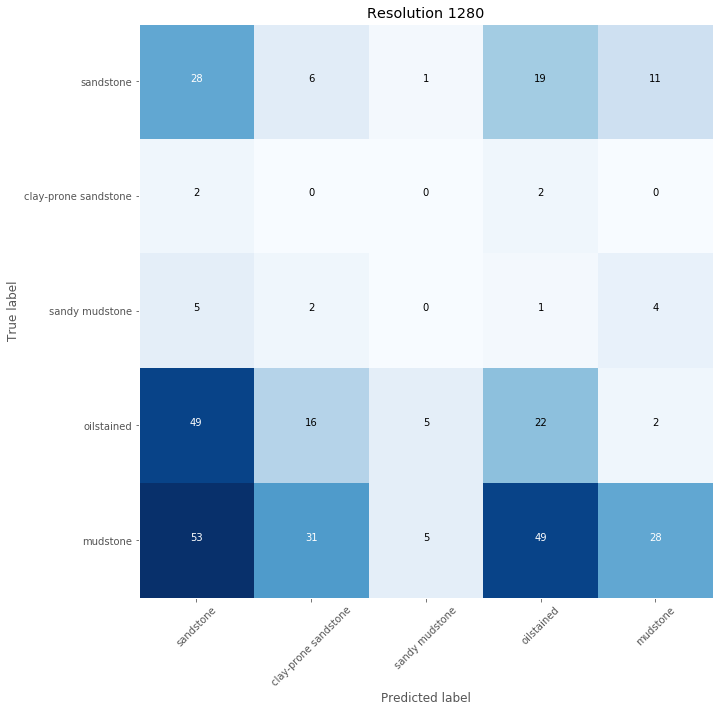

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (305,)), ('top', (305,)), ('base', (305,)), ('logs', (305, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (449,)), ('top', (449,)), ('base', (449,)), ('logs', (449, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (253,)), ('top', (253,)), ('base', (253,)), ('logs', (253, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (68,)), ('top', (68,)), ('base', (68,)), ('logs', (68, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (226,)), ('top', (226,)), ('base', (226,)), ('logs', (226, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (92,)), ('top', (92,)), ('base', (92,)), ('logs', (92, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (69,)), ('top', (69,)), ('base', (69,)), ('logs', (69, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (231,)), ('top', (231,)), ('base', (231,)), ('logs', (231, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (45,)), ('top', (45,)), ('base', (45,)), ('logs', (45, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (79,)), ('top', (79,)), ('base', (79,)), ('logs', (79, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (45,)), ('top', (45,)), ('base', (45,)), ('logs', (45, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (262,)), ('top', (262,)), ('base', (262,)), ('logs', (262, 11))]
Training model for feature:  logs
F1 score: 0.13958424043192405
Training model for feature:  logs
F1 score: 0.17704591381173923
Training model for feature:  logs
F1 score: 0.18942865056284247
Training model for feature:  logs
F1 score: 0.1459224309466797
Training model for feature:  logs
F1 score: 0.16191362401039816
Training model for feature:  logs
F1 score: 0.15495414822721948
Training model for feature:  logs
F1 score: 0.2121699319841735
Training model for feature:  logs
F1 score: 0.15931424959160406
Training model for feature:  logs
F1 score: 0.14502489991211792
Training model for feature:  logs
F1 score: 0.1400817291629186
Training model for feature:  logs
F1 score: 0.10799396681749625
Training model for feature:  logs
F1 score: 0.16654369784804568
Training model for feature:  logs
F1 score: 0.1875613924418882
Training model for feature:  logs
F

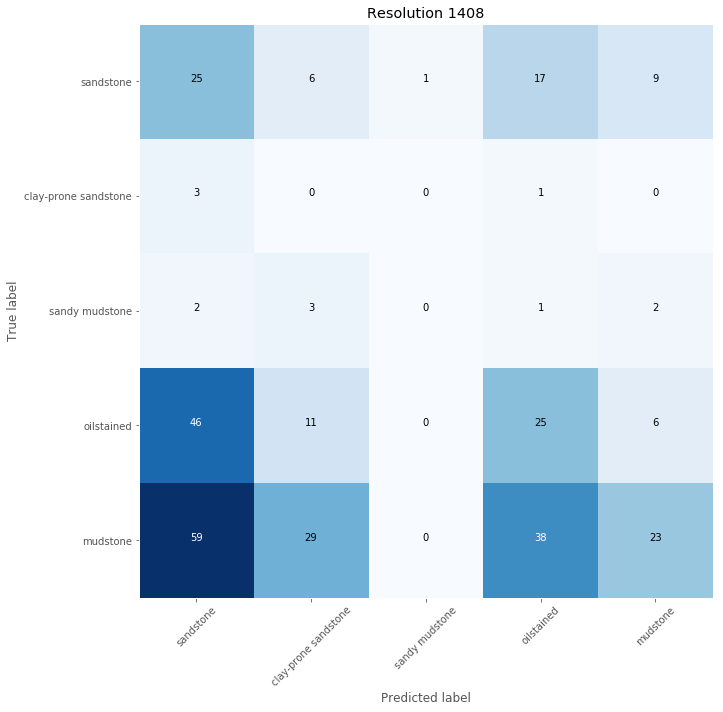

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (283,)), ('top', (283,)), ('base', (283,)), ('logs', (283, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (410,)), ('top', (410,)), ('base', (410,)), ('logs', (410, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (238,)), ('top', (238,)), ('base', (238,)), ('logs', (238, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (63,)), ('top', (63,)), ('base', (63,)), ('logs', (63, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (199,)), ('top', (199,)), ('base', (199,)), ('logs', (199, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (85,)), ('top', (85,)), ('base', (85,)), ('logs', (85, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (66,)), ('top', (66,)), ('base', (66,)), ('logs', (66, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (213,)), ('top', (213,)), ('base', (213,)), ('logs', (213, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (74,)), ('top', (74,)), ('base', (74,)), ('logs', (74, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (42,)), ('top', (42,)), ('base', (42,)), ('logs', (42, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (245,)), ('top', (245,)), ('base', (245,)), ('logs', (245, 11))]
Training model for feature:  logs
F1 score: 0.16227059247686576
Training model for feature:  logs
F1 score: 0.13765857351006106
Training model for feature:  logs
F1 score: 0.19159412869090287
Training model for feature:  logs
F1 score: 0.16760500976069836
Training model for feature:  logs
F1 score: 0.17974173653614675
Training model for feature:  logs
F1 score: 0.17369210977701546
Training model for feature:  logs
F1 score: 0.15810416416749543
Training model for feature:  logs
F1 score: 0.175459644615714
Training model for feature:  logs
F1 score: 0.17776785714285714
Training model for feature:  logs
F1 score: 0.16601897378167596
Training model for feature:  logs
F1 score: 0.15074958318293544
Training model for feature:  logs
F1 score: 0.1617984118092853
Training model for feature:  logs
F1 score: 0.16769743020575428
Training model for feature:  logs


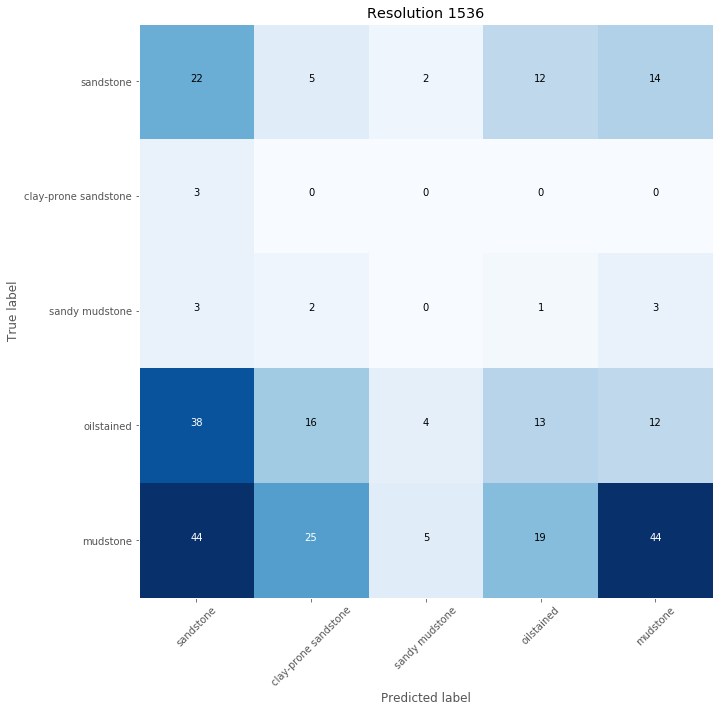

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (247,)), ('top', (247,)), ('base', (247,)), ('logs', (247, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (355,)), ('top', (355,)), ('base', (355,)), ('logs', (355, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (201,)), ('top', (201,)), ('base', (201,)), ('logs', (201, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (53,)), ('top', (53,)), ('base', (53,)), ('logs', (53, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (178,)), ('top', (178,)), ('base', (178,)), ('logs', (178, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (74,)), ('top', (74,)), ('base', (74,)), ('logs', (74, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (56,)), ('top', (56,)), ('base', (56,)), ('logs', (56, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (180,)), ('top', (180,)), ('base', (180,)), ('logs', (180, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (34,)), ('top', (34,)), ('base', (34,)), ('logs', (34, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (63,)), ('top', (63,)), ('base', (63,)), ('logs', (63, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (202,)), ('top', (202,)), ('base', (202,)), ('logs', (202, 11))]
Training model for feature:  logs
F1 score: 0.16485420524333114
Training model for feature:  logs
F1 score: 0.1745950985970434
Training model for feature:  logs
F1 score: 0.19814432989690722
Training model for feature:  logs
F1 score: 0.15304479626953132
Training model for feature:  logs
F1 score: 0.12825463941743012
Training model for feature:  logs
F1 score: 0.12614291479303585
Training model for feature:  logs
F1 score: 0.13530435302559196
Training model for feature:  logs
F1 score: 0.17401889225454062
Training model for feature:  logs
F1 score: 0.1554027075924886
Training model for feature:  logs
F1 score: 0.1509928909011478
Training model for feature:  logs
F1 score: 0.17857133838315514
Training model for feature:  logs
F1 score: 0.1575984015984016
Training model for feature:  logs
F1 score: 0.17067158706502966
Training model for feature:  logs
F

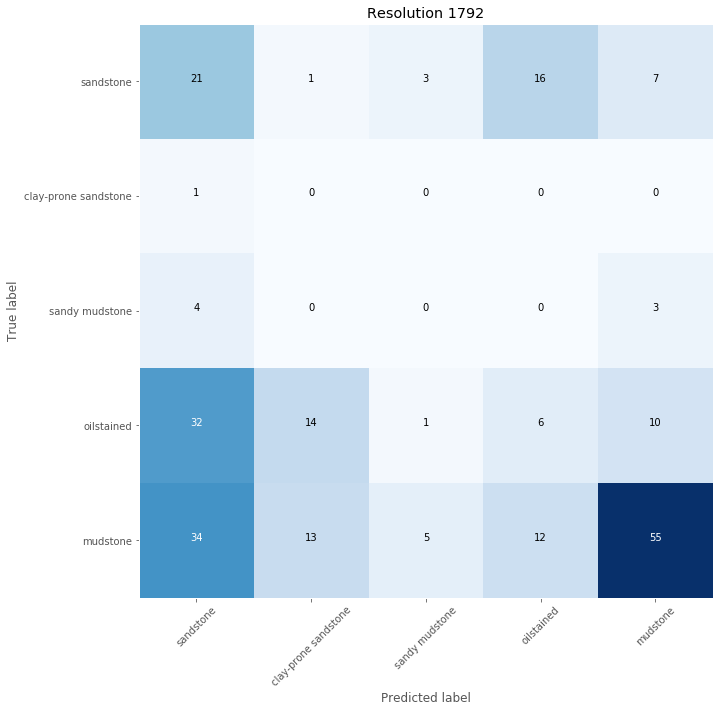

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (232,)), ('top', (232,)), ('base', (232,)), ('logs', (232, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (339,)), ('top', (339,)), ('base', (339,)), ('logs', (339, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (184,)), ('top', (184,)), ('base', (184,)), ('logs', (184, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (50,)), ('top', (50,)), ('base', (50,)), ('logs', (50, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (158,)), ('top', (158,)), ('base', (158,)), ('logs', (158, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (68,)), ('top', (68,)), ('base', (68,)), ('logs', (68, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (52,)), ('top', (52,)), ('base', (52,)), ('logs', (52, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (171,)), ('top', (171,)), ('base', (171,)), ('logs', (171, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (33,)), ('top', (33,)), ('base', (33,)), ('logs', (33, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (61,)), ('top', (61,)), ('base', (61,)), ('logs', (61, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (34,)), ('top', (34,)), ('base', (34,)), ('logs', (34, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (198,)), ('top', (198,)), ('base', (198,)), ('logs', (198, 11))]
Training model for feature:  logs
F1 score: 0.13511560587063942
Training model for feature:  logs
F1 score: 0.18188571835195333
Training model for feature:  logs
F1 score: 0.17284465534465535
Training model for feature:  logs
F1 score: 0.20510130931125897
Training model for feature:  logs
F1 score: 0.1709617043870711
Training model for feature:  logs
F1 score: 0.18471521128067617
Training model for feature:  logs
F1 score: 0.2296728376728377
Training model for feature:  logs
F1 score: 0.22783205801012735
Training model for feature:  logs
F1 score: 0.19604788861499586
Training model for feature:  logs
F1 score: 0.16366378301384055
Training model for feature:  logs
F1 score: 0.18579821200510857
Training model for feature:  logs
F1 score: 0.1895599042780442
Training model for feature:  logs
F1 score: 0.18392650360392296
Training model for feature:  logs


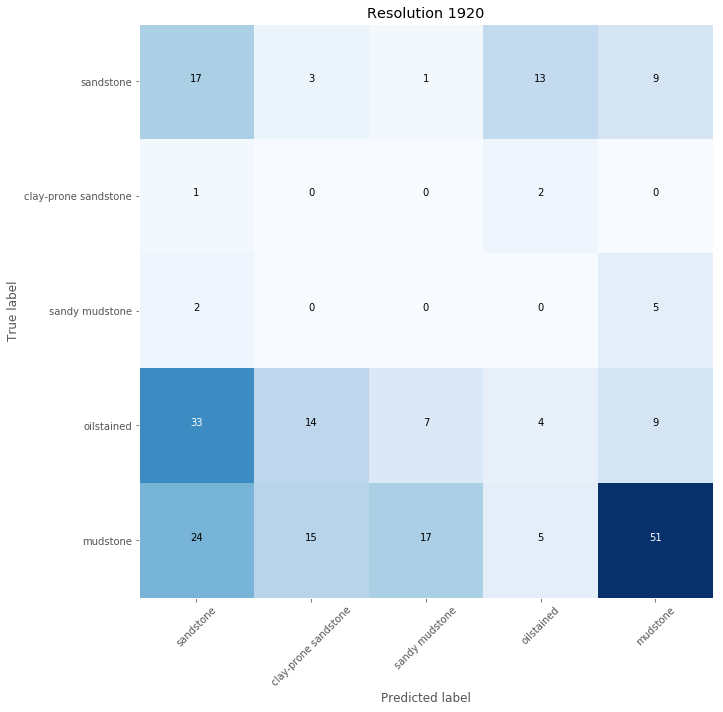

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (208,)), ('top', (208,)), ('base', (208,)), ('logs', (208, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (297,)), ('top', (297,)), ('base', (297,)), ('logs', (297, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (164,)), ('top', (164,)), ('base', (164,)), ('logs', (164, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (44,)), ('top', (44,)), ('base', (44,)), ('logs', (44, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (142,)), ('top', (142,)), ('base', (142,)), ('logs', (142, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (59,)), ('top', (59,)), ('base', (59,)), ('logs', (59, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (46,)), ('top', (46,)), ('base', (46,)), ('logs', (46, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (154,)), ('top', (154,)), ('base', (154,)), ('logs', (154, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (28,)), ('top', (28,)), ('base', (28,)), ('logs', (28, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (51,)), ('top', (51,)), ('base', (51,)), ('logs', (51, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (29,)), ('top', (29,)), ('base', (29,)), ('logs', (29, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (176,)), ('top', (176,)), ('base', (176,)), ('logs', (176, 11))]
Training model for feature:  logs
F1 score: 0.17352554292470454
Training model for feature:  logs
F1 score: 0.2019511063156255
Training model for feature:  logs
F1 score: 0.18407407407407408
Training model for feature:  logs


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score: 0.15997076223192672
Training model for feature:  logs
F1 score: 0.170518241448474
Training model for feature:  logs
F1 score: 0.1810579479000532
Training model for feature:  logs
F1 score: 0.2016233766233766
Training model for feature:  logs
F1 score: 0.17888159312307922
Training model for feature:  logs


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score: 0.14845878103796656
Training model for feature:  logs
F1 score: 0.20198537095088823
Training model for feature:  logs
F1 score: 0.1670973538617797
Training model for feature:  logs
F1 score: 0.18820980844448904
Training model for feature:  logs
F1 score: 0.21155132156533113
Training model for feature:  logs
F1 score: 0.1868801004394225
Training model for feature:  logs
F1 score: 0.19040438871473353
Fitting best model for resolution multiplier: 68
Training model for feature:  logs
                      precision    recall  f1-score   support

           sandstone       0.20      0.30      0.24        37
clay-prone sandstone       0.00      0.00      0.00         1
      sandy mudstone       0.00      0.00      0.00         6
          oilstained       0.18      0.11      0.13        55
            mudstone       0.68      0.59      0.63       106

           micro avg       0.39      0.39      0.39       205
           macro avg       0.21      0.20      0.20       205
       

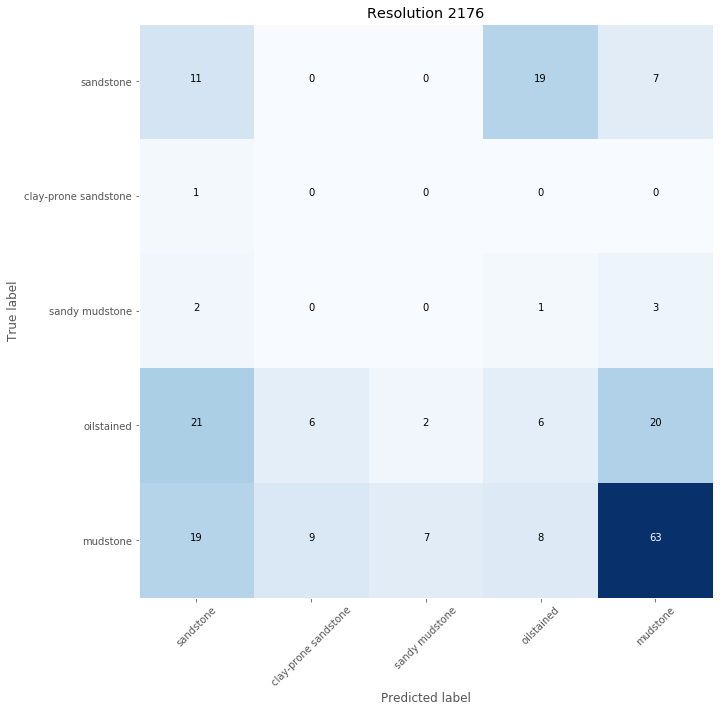

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (192,)), ('top', (192,)), ('base', (192,)), ('logs', (192, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (279,)), ('top', (279,)), ('base', (279,)), ('logs', (279, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (158,)), ('top', (158,)), ('base', (158,)), ('logs', (158, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (43,)), ('top', (43,)), ('base', (43,)), ('logs', (43, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (135,)), ('top', (135,)), ('base', (135,)), ('logs', (135, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (55,)), ('top', (55,)), ('base', (55,)), ('logs', (55, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (42,)), ('top', (42,)), ('base', (42,)), ('logs', (42, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (142,)), ('top', (142,)), ('base', (142,)), ('logs', (142, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (26,)), ('top', (26,)), ('base', (26,)), ('logs', (26, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (51,)), ('top', (51,)), ('base', (51,)), ('logs', (51, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (28,)), ('top', (28,)), ('base', (28,)), ('logs', (28, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (161,)), ('top', (161,)), ('base', (161,)), ('logs', (161, 11))]
Training model for feature:  logs
F1 score: 0.12447855175127902
Training model for feature:  logs
F1 score: 0.1877305905773059
Training model for feature:  logs
F1 score: 0.13917282430213468
Training model for feature:  logs
F1 score: 0.18254447331859847
Training model for feature:  logs
F1 score: 0.14126440997910372
Training model for feature:  logs
F1 score: 0.14065762817515975
Training model for feature:  logs
F1 score: 0.17252149982800136
Training model for feature:  logs
F1 score: 0.17507940629489344
Training model for feature:  logs
F1 score: 0.17285338435780914
Training model for feature:  logs
F1 score: 0.16770113391421057
Training model for feature:  logs
F1 score: 0.16693257848687598
Training model for feature:  logs
F1 score: 0.16022865572561312
Training model for feature:  logs
F1 score: 0.1286475618904726
Training model for feature:  logs

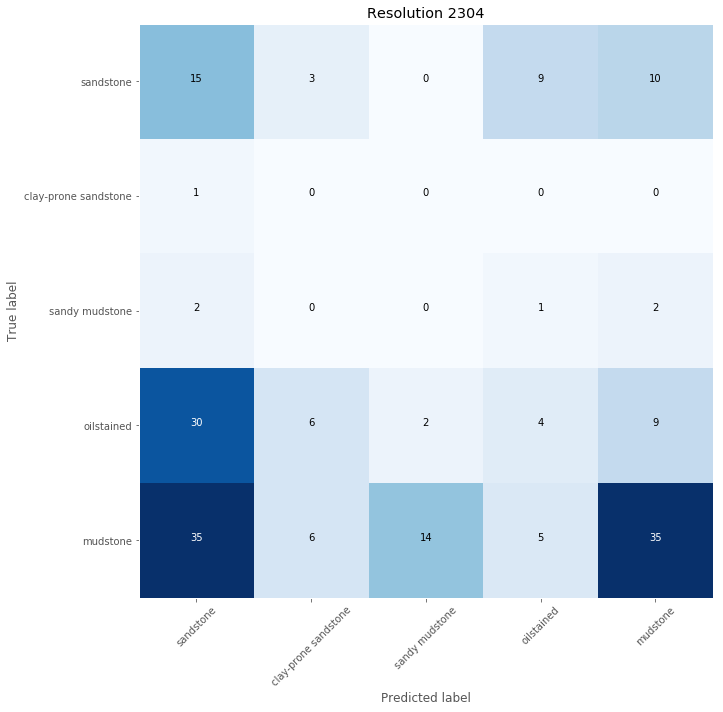

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (177,)), ('top', (177,)), ('base', (177,)), ('logs', (177, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (255,)), ('top', (255,)), ('base', (255,)), ('logs', (255, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (143,)), ('top', (143,)), ('base', (143,)), ('logs', (143, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (38,)), ('top', (38,)), ('base', (38,)), ('logs', (38, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (119,)), ('top', (119,)), ('base', (119,)), ('logs', (119, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (52,)), ('top', (52,)), ('base', (52,)), ('logs', (52, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (38,)), ('top', (38,)), ('base', (38,)), ('logs', (38, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (130,)), ('top', (130,)), ('base', (130,)), ('logs', (130, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (25,)), ('top', (25,)), ('base', (25,)), ('logs', (25, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (44,)), ('top', (44,)), ('base', (44,)), ('logs', (44, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (25,)), ('top', (25,)), ('base', (25,)), ('logs', (25, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (146,)), ('top', (146,)), ('base', (146,)), ('logs', (146, 11))]
Training model for feature:  logs
F1 score: 0.1660705882352941
Training model for feature:  logs
F1 score: 0.14117053853627343
Training model for feature:  logs
F1 score: 0.14345413446708505
Training model for feature:  logs
F1 score: 0.12401182266009851
Training model for feature:  logs
F1 score: 0.14911203888334995
Training model for feature:  logs
F1 score: 0.18536873822975516
Training model for feature:  logs
F1 score: 0.14820628212867937
Training model for feature:  logs
F1 score: 0.150825305616585
Training model for feature:  logs
F1 score: 0.17037625861155273
Training model for feature:  logs
F1 score: 0.1338598901098901
Training model for feature:  logs
F1 score: 0.1692318776191448
Training model for feature:  logs
F1 score: 0.14677116462214143
Training model for feature:  logs
F1 score: 0.1285307621671258
Training model for feature:  logs
F1 

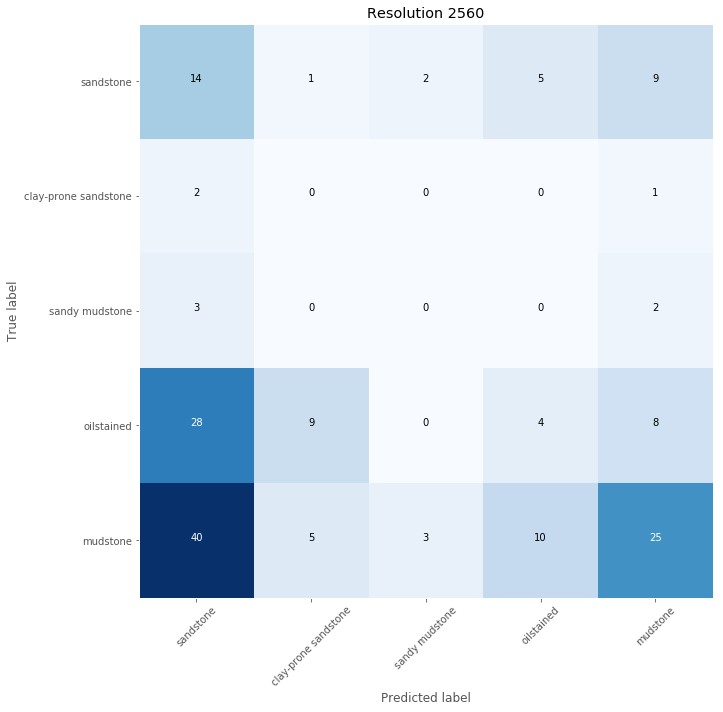

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (165,)), ('top', (165,)), ('base', (165,)), ('logs', (165, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (242,)), ('top', (242,)), ('base', (242,)), ('logs', (242, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (139,)), ('top', (139,)), ('base', (139,)), ('logs', (139, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (115,)), ('top', (115,)), ('base', (115,)), ('logs', (115, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (50,)), ('top', (50,)), ('base', (50,)), ('logs', (50, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (123,)), ('top', (123,)), ('base', (123,)), ('logs', (123, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (23,)), ('top', (23,)), ('base', (23,)), ('logs', (23, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (44,)), ('top', (44,)), ('base', (44,)), ('logs', (44, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (24,)), ('top', (24,)), ('base', (24,)), ('logs', (24, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (143,)), ('top', (143,)), ('base', (143,)), ('logs', (143, 11))]
Training model for feature:  logs
F1 score: 0.1714238830461699
Training model for feature:  logs
F1 score: 0.1606860287974839
Training model for feature:  logs
F1 score: 0.1963325563325563
Training model for feature:  logs
F1 score: 0.17757422969187675
Training model for feature:  logs
F1 score: 0.21845759873928888
Training model for feature:  logs
F1 score: 0.1786718049863679
Training model for feature:  logs


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score: 0.1922584847892645
Training model for feature:  logs
F1 score: 0.16333333333333333
Training model for feature:  logs
F1 score: 0.20209210061277622
Training model for feature:  logs
F1 score: 0.1638024305976482
Training model for feature:  logs
F1 score: 0.2251372774526717
Training model for feature:  logs
F1 score: 0.2031485401493887
Training model for feature:  logs
F1 score: 0.1993333333333333
Training model for feature:  logs
F1 score: 0.23091745892983964
Training model for feature:  logs
F1 score: 0.20044444444444448
Fitting best model for resolution multiplier: 84
Training model for feature:  logs
                      precision    recall  f1-score   support

           sandstone       0.23      0.52      0.31        31
clay-prone sandstone       0.00      0.00      0.00         3
      sandy mudstone       0.00      0.00      0.00         4
          oilstained       0.29      0.17      0.22        46
            mudstone       0.72      0.51      0.60        83

      

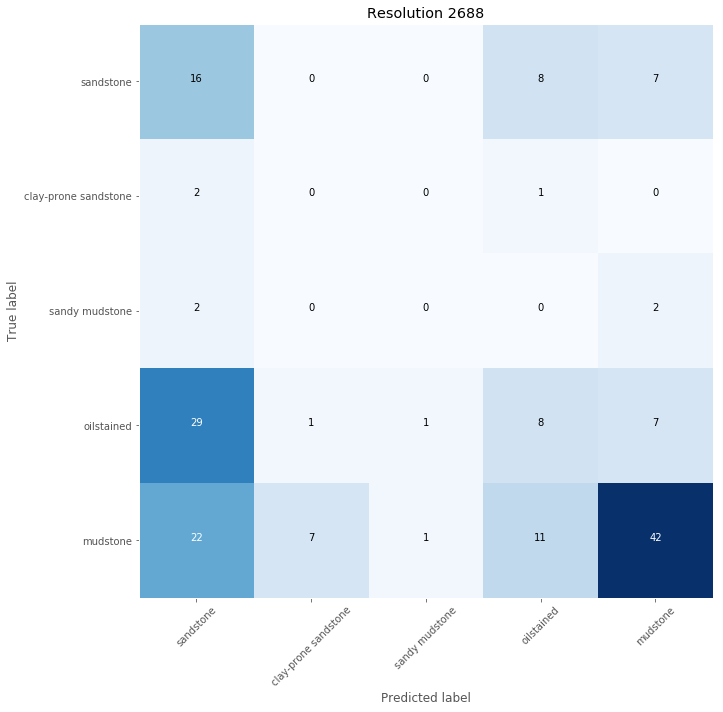

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (157,)), ('top', (157,)), ('base', (157,)), ('logs', (157, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (225,)), ('top', (225,)), ('base', (225,)), ('logs', (225, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (125,)), ('top', (125,)), ('base', (125,)), ('logs', (125, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (99,)), ('top', (99,)), ('base', (99,)), ('logs', (99, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (45,)), ('top', (45,)), ('base', (45,)), ('logs', (45, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (33,)), ('top', (33,)), ('base', (33,)), ('logs', (33, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (115,)), ('top', (115,)), ('base', (115,)), ('logs', (115, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (22,)), ('top', (22,)), ('base', (22,)), ('logs', (22, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (43,)), ('top', (43,)), ('base', (43,)), ('logs', (43, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (23,)), ('top', (23,)), ('base', (23,)), ('logs', (23, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (134,)), ('top', (134,)), ('base', (134,)), ('logs', (134, 11))]
Training model for feature:  logs
F1 score: 0.1589983948635634
Training model for feature:  logs
F1 score: 0.17223237637459735
Training model for feature:  logs
F1 score: 0.15495157763199002
Training model for feature:  logs
F1 score: 0.17453414311912135
Training model for feature:  logs
F1 score: 0.1938335349637724
Training model for feature:  logs
F1 score: 0.18495089140250429
Training model for feature:  logs
F1 score: 0.19263496523770496
Training model for feature:  logs
F1 score: 0.18620284805332524
Training model for feature:  logs
F1 score: 0.19514135990166268
Training model for feature:  logs
F1 score: 0.15381023988542783
Training model for feature:  logs
F1 score: 0.15997574088644112
Training model for feature:  logs
F1 score: 0.18322129871850062
Training model for feature:  logs
F1 score: 0.19306839792773295
Training model for feature:  logs

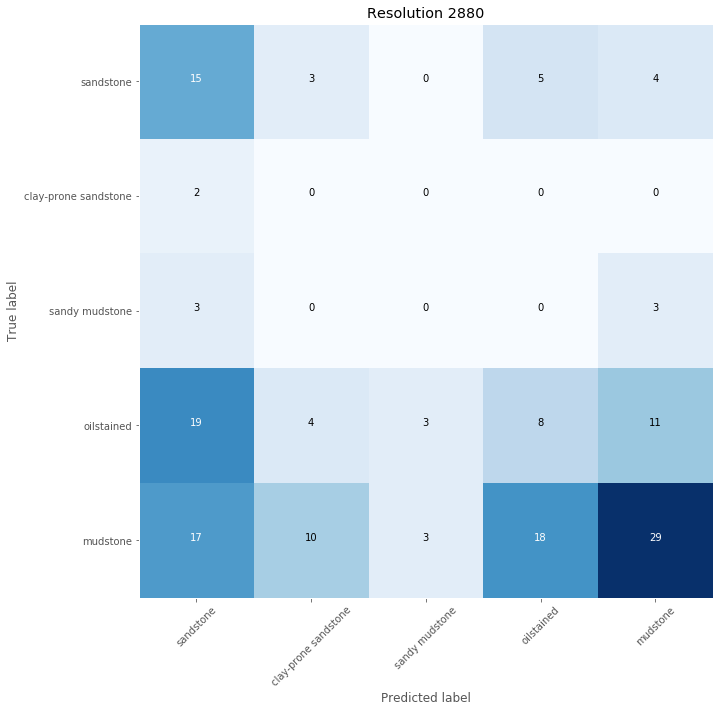

Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (146,)), ('top', (146,)), ('base', (146,)), ('logs', (146, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (211,)), ('top', (211,)), ('base', (211,)), ('logs', (211, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (119,)), ('top', (119,)), ('base', (119,)), ('logs', (119, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (29,)), ('top', (29,)), ('base', (29,)), ('logs', (29, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (99,)), ('top', (99,)), ('base', (99,)), ('logs', (99, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (46,)), ('top', (46,)), ('base', (46,)), ('logs', (46, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (33,)), ('top', (33,)), ('base', (33,)), ('logs', (33, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (107,)), ('top', (107,)), ('base', (107,)), ('logs', (107, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (21,)), ('top', (21,)), ('base', (21,)), ('logs', (21, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (40,)), ('top', (40,)), ('base', (40,)), ('logs', (40, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (21,)), ('top', (21,)), ('base', (21,)), ('logs', (21, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (126,)), ('top', (126,)), ('base', (126,)), ('logs', (126, 11))]
Training model for feature:  logs
F1 score: 0.20226370331317858
Training model for feature:  logs
F1 score: 0.17024992147888904
Training model for feature:  logs
F1 score: 0.18616495288595894
Training model for feature:  logs
F1 score: 0.2178196742899785
Training model for feature:  logs
F1 score: 0.20273504273504273
Training model for feature:  logs
F1 score: 0.1821505376344086
Training model for feature:  logs
F1 score: 0.16923364311399616
Training model for feature:  logs
F1 score: 0.21027223230490016
Training model for feature:  logs
F1 score: 0.19671685763934832
Training model for feature:  logs
F1 score: 0.18300262350811072
Training model for feature:  logs
F1 score: 0.20687391555812612
Training model for feature:  logs
F1 score: 0.2061224489795918
Training model for feature:  logs
F1 score: 0.21224188790560472
Training model for feature:  logs


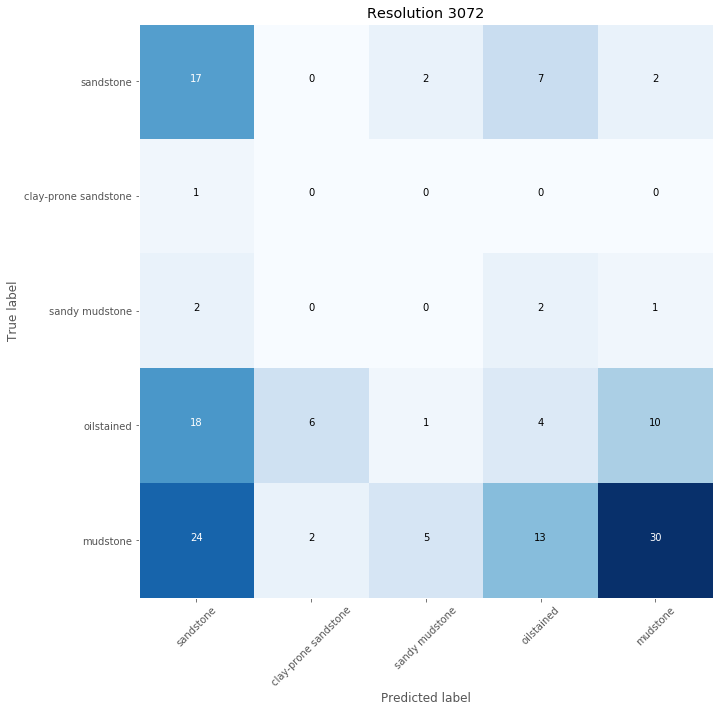

In [39]:
EVALS_PER_SEARCH = 15
RESOLUTION_MULTIPLIERS = [2, 4, 8, 10, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 56, 60, 68, 72, 80, 84, 90, 96]

results = {'resolution_multiplier' : [], 'acc' : [], 'f1' : []}

for rmult in RESOLUTION_MULTIPLIERS:
    
    fdset = FaciesDataset(TRAIN_WELLS, test_wells=TEST_WELLS,
            features=["logs"],
            label_resolution=32*rmult, # 32 pixels ~ .5cm
            logs_args={'scaler_kind': 'standard'})
    
    fdset.load_or_generate_data()
    
    best_params = make_params_usable(
        hyperopt.fmin(
            fn=lambda p: train_xgb_model(p, fdset),
            space=XGB_SEARCH_SPACE,
            algo=hyperopt.rand.suggest,
            max_evals=EVALS_PER_SEARCH
        )
    )
    
    best_model = FeaturePredictor(fdset, model_args=best_params, feature_model_args=fmodel_args)
    
    print(f'Fitting best model for resolution multiplier: {rmult}')
    best_model.fit(fdset, verbose=True)
    
    y_pred = best_model.predict(fdset.X_test)
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot({'y_true' : fdset.y_test, 'y_pred' : y_pred}, 
                                       fdset.classes, title=f'Resolution {rmult*32}', ax=ax)
    plt.show()
    
    results['resolution_multiplier'].append(rmult)
    results['acc'].append(accuracy_score(fdset.y_test, y_pred))
    results['f1'].append(f1_score(fdset.y_test, y_pred, average='macro'))

params = {
    **XGB_SEARCH_SPACE, 
    **best_params, 
    **{'max_depth' : int(best_params['max_depth']), 
       'n_estimators' : int(best_params['n_estimators'])}
}
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=fmodel_args)
xgb_predictor.fit(fdset, verbose=True)

imps = list(zip(fdset.wells[0].logs_args['which_logs'], xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
for pair in imps[::-1]:
    print(pair)

import matplotlib.pyplot as plt
from coremdlr.viz import model_plots 

pred_dfs = []

for test_well_name in fdset.test_well_names:
    df = xgb_predictor.preds_dataframe(test_well_name, logs=fdset.logs_args['which_logs'])
    df['well'] = test_well_name
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot(df, fdset.classes, title=test_well_name, ax=ax)
    
    pred_dfs.append(df)
    
pred_df = pd.concat(pred_dfs)

In [40]:
results

{'resolution_multiplier': [2,
  4,
  8,
  10,
  12,
  16,
  20,
  24,
  28,
  32,
  36,
  40,
  44,
  48,
  56,
  60,
  68,
  72,
  80,
  84,
  90,
  96],
 'acc': [0.3105078542016166,
  0.324398416082851,
  0.39853747714808047,
  0.3919022154316272,
  0.308675799086758,
  0.3595641646489104,
  0.36722306525037934,
  0.2857142857142857,
  0.28842105263157897,
  0.26987951807228916,
  0.2546916890080429,
  0.2287390029325513,
  0.23778501628664495,
  0.27526132404181186,
  0.3445378151260504,
  0.3103448275862069,
  0.3902439024390244,
  0.2857142857142857,
  0.25146198830409355,
  0.39520958083832336,
  0.33121019108280253,
  0.3469387755102041],
 'f1': [0.19934066786675397,
  0.2228159827749797,
  0.2091353979961851,
  0.23900593509883938,
  0.19582458266460973,
  0.2535275129937083,
  0.22076058116071162,
  0.19868102775312307,
  0.20064903588488772,
  0.19273988624529365,
  0.1707643794558209,
  0.15558493680424637,
  0.15931424959160406,
  0.17776785714285714,
  0.19814432989690722,

In [41]:
results['resolution_multiplier']

[2,
 4,
 8,
 10,
 12,
 16,
 20,
 24,
 28,
 32,
 36,
 40,
 44,
 48,
 56,
 60,
 68,
 72,
 80,
 84,
 90,
 96]

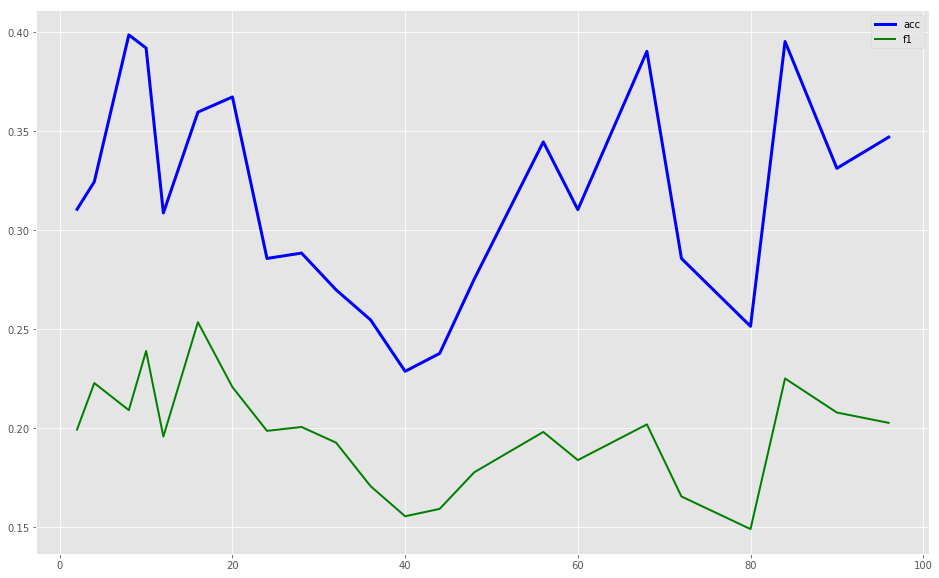

In [42]:
plt.figure(figsize=(16,10))
plt.plot(results['resolution_multiplier'],results['acc'],color='b', linewidth=3)
plt.plot(results['resolution_multiplier'],results['f1'], color='g', linewidth=2)
plt.legend(['acc', 'f1'])


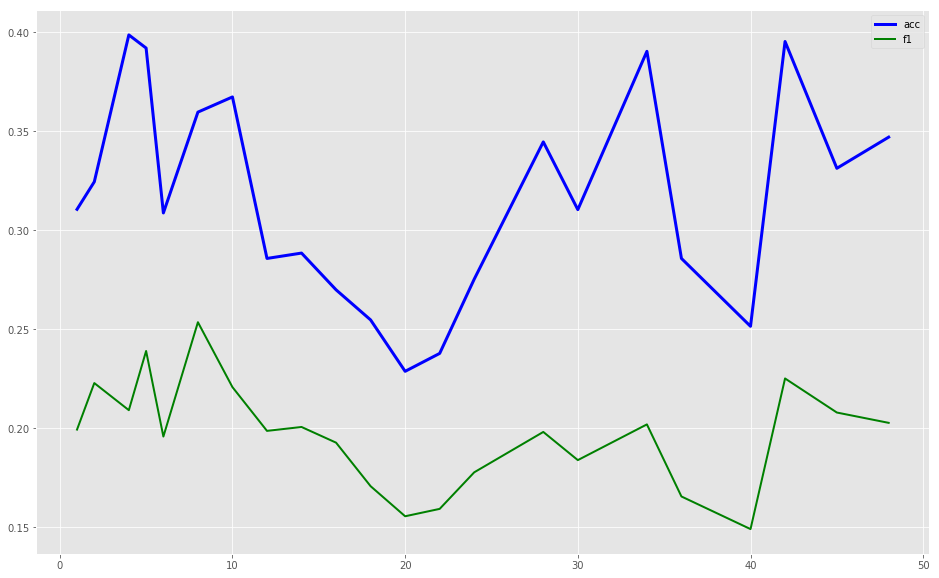

In [43]:
# same thing with approximate resolution in centimeters
# 64 rows ~ 1 cm
resolutions = [r / 2. for r in results['resolution_multiplier']]

plt.figure(figsize=(16,10))
plt.plot(resolutions, results['acc'], color='b', linewidth=3)
plt.plot(resolutions, results['f1'], color='g', linewidth=2)
plt.legend(['acc', 'f1'])